Test notebook for creating a binary classification map of cultivated vs uncultivated areas

Go to user inputs, enter info, then run the cells.

Use the 'data exploration plots' to help determine suitable threshold values

In [3]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

import datacube 
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking

dc = datacube.Datacube(app='cultivated_areas')

import sys
sys.path.append('src/')
import DEAPlotting, SpatialTools, BandIndices

## User Inputs

In [104]:
NDMI_theshold = 0.3
mads_theshold = 0.1
wofs_theshold = 0.15

lat, lon = -19.349926, 146.780920
latLon_adjust = 0.1
time_period = ('2015-01-01', '2015-12-31')

export_results = True
results = 'results/cultivated_land_01_wofs_townsville_MADS_201501_201512.tif'

#Forbes# -33.386631, 148.001984  tamworth -31.105232, 150.937345  cooryong -36.200347, 147.903574  garalema-29.496685, 149.064733

#townsville -19.349926, 146.780920
pixel_size_x = 100
pixel_size_y = -100

min_x = 1500000.000
max_x = 1600000.000
min_y = -2200000.000
max_y = -2100000.000

out_crs = "EPSG:3577"

## load data

In [15]:
ls8_mads = dc.load(product="ls8_nbart_tmad_annual",
                     x=(min_x, max_x),
                     y=(min_y, max_y),
                     crs=out_crs,
                     resolution=(pixel_size_x, pixel_size_y),
                     time=(time_period))

<xarray.Dataset>
Dimensions:  (time: 1, x: 1000, y: 1000)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01
  * y        (y) float64 -2.2e+06 -2.2e+06 -2.2e+06 -2.2e+06 -2.2e+06 ...
  * x        (x) float64 1.6e+06 1.6e+06 1.6e+06 1.6e+06 1.6e+06 1.599e+06 ...
Data variables:
    sdev     (time, y, x) float32 0.0057153087 0.0045149713 0.003508349 ...
    edev     (time, y, x) float32 0.08747198 0.07260348 0.089377776 ...
    bcdev    (time, y, x) float32 0.074039854 0.070970684 0.065178715 ...
Attributes:
    crs:      EPSG:3577

In [20]:
#load WOfS
wofs_annual = dc.load(product = 'wofs_annual_summary', x=(min_x, max_x),
                     y=(min_y, max_y),
                     crs=out_crs,
                     resolution=(pixel_size_x, pixel_size_y))

<xarray.Dataset>
Dimensions:      (time: 32, x: 1000, y: 1000)
Coordinates:
  * time         (time) datetime64[ns] 1986-01-01 1987-01-01 1988-01-01 ...
  * y            (y) float64 -2.2e+06 -2.2e+06 -2.2e+06 -2.2e+06 -2.2e+06 ...
  * x            (x) float64 1.6e+06 1.6e+06 1.6e+06 1.6e+06 1.6e+06 ...
Data variables:
    count_wet    (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    count_clear  (time, y, x) int16 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    frequency    (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
Attributes:
    crs:      EPSG:3577

In [17]:
ls8_gm = dc.load(product="ls8_nbart_geomedian_annual",
                     x=(min_x, max_x),
                     y=(min_y, max_y),
                     crs=out_crs,
                     resolution=(pixel_size_x, pixel_size_y),
                     time=(time_period))

<xarray.Dataset>
Dimensions:  (time: 1, x: 1000, y: 1000)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01
  * y        (y) float64 -2.2e+06 -2.2e+06 -2.2e+06 -2.2e+06 -2.2e+06 ...
  * x        (x) float64 1.6e+06 1.6e+06 1.6e+06 1.6e+06 1.6e+06 1.599e+06 ...
Data variables:
    blue     (time, y, x) int16 748 551 502 573 567 499 488 485 562 539 586 ...
    green    (time, y, x) int16 1042 984 881 919 853 811 801 837 913 921 948 ...
    red      (time, y, x) int16 1055 661 641 915 701 596 561 536 666 659 690 ...
    nir      (time, y, x) int16 3308 4908 4419 3346 4364 4563 4458 4648 3827 ...
    swir1    (time, y, x) int16 2677 1886 1962 2242 1991 1816 1632 1731 1897 ...
    swir2    (time, y, x) int16 1844 872 1010 1414 1013 897 748 787 998 938 ...
Attributes:
    crs:      EPSG:3577

## band indices

In [105]:
#calculate band indices
#NDVI_landsat = BandIndices.calculate_indices(ls8_gm, index='NDVI')
NDMI_gm = BandIndices.calculate_indices(ls8_gm, index='NDMI-nir')

# #calculate per pixel summary stats
# NDVI_std = NDVI_landsat.groupby('x','y').std('time')
# NDVI_max = NDVI_landsat.groupby('x','y').max('time')
# NDMI_max = NDMI_landsat.groupby('x','y').max('time')

#calculate stats of stats
# median_of_max = np.median(NDVI_max.values)
# median_of_std = np.median(NDVI_std.values)

The formula we are using is (nir - swir1)/(nir + swir1)


## data exploration plots

(array([5.36907e+05, 3.15553e+05, 1.14200e+05, 2.40710e+04, 7.06300e+03,
        1.73400e+03, 3.39000e+02, 1.04000e+02, 2.20000e+01, 7.00000e+00]),
 array([0.00264457, 0.03790675, 0.07316893, 0.10843111, 0.14369328,
        0.17895547, 0.21421765, 0.24947983, 0.284742  , 0.3200042 ,
        0.35526636], dtype=float32),
 <a list of 10 Patch objects>)

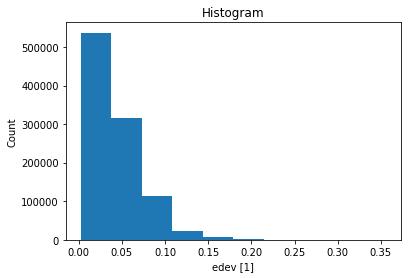

In [95]:
ls8_mads.edev.plot.hist(bins=10)

## reclassify

In [106]:
#reclassify using thresholds
NDMI_gm_np = NDMI_gm[0].values
NDMI_gm_np = np.where(NDMI_gm_np >= NDMI_theshold, 1, 0)
NDMI_gm_np = NDMI_gm_np.astype(int)

wofs_annual_np = wofs_alltime.frequency[0].values
wofs_annual_np = np.where(wofs_annual_np > wofs_theshold, 0, 1)
wofs_annual_np = wofs_annual_np.astype(int)

In [107]:
sdevs = ls8_mads.edev[0]
sdevs_np = sdevs.values
sdevs_np = np.where(sdevs_np >= mads_theshold, 1, 0)
sdevs_np = sdevs_np.astype(int)

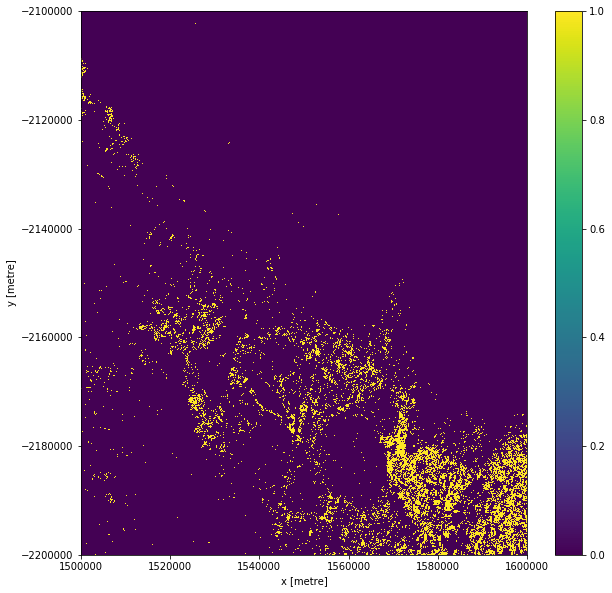

In [108]:
y = NDMI_gm.coords['y']
x = NDMI_gm.coords['x']
xr.DataArray(sdevs_np, coords = [y, x], dims = ['y', 'x']).plot(figsize=(10,10))

## raster math, indexing

In [111]:
#raster math to arrive at cropping areas
cropped_areas = sdevs_np
cropped_areas = np.where(cropped_areas >= 1, 1, 0)
cropped_areas = cropped_areas.astype(int)

#remove water
cropped_areas = np.where(wofs_annual_np, cropped_areas, 0)
cropped_areas = cropped_areas.astype(int)

#rebuild xarray
y = NDMI_gm.coords['y']
x = NDMI_gm.coords['x']
cropped_areas_xr = xr.DataArray(cropped_areas, coords = [y, x], dims = ['y', 'x'], name='cropped_areas')

## plotting then exporting as geotiff

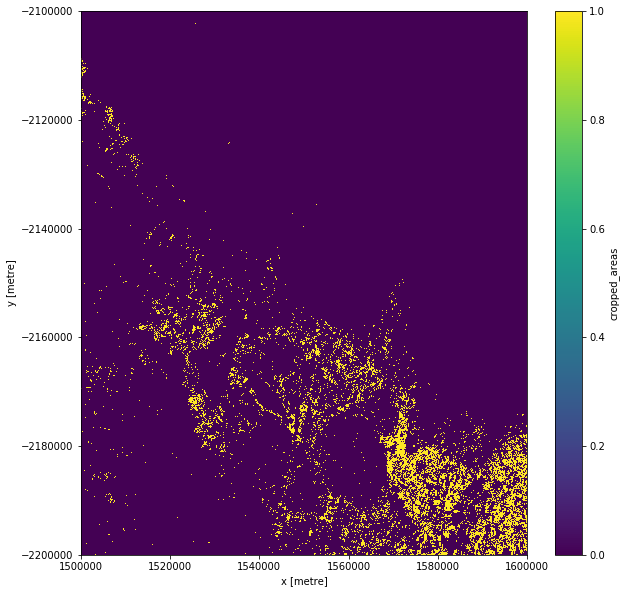

In [112]:
cropped_areas_xr.plot(figsize=(10,10))

In [113]:
#create 'transform' tuple that will define the dimensions of the rasterized shapefile and exporty
if export_results == True:
    import osr
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(3577)
    prj_wkt = srs.ExportToWkt()

    easting = float(cropped_areas_xr.x[0])
    W_E_pixelRes = float(cropped_areas_xr.y[0] - cropped_areas_xr.y[1])
    rotation = 0.0 #(if image is 'north up')
    northing = float(cropped_areas_xr.y[0])
    rotation1 = 0.0 #(if image is 'north up')
    N_S_pixelRes = float(cropped_areas_xr.x[0] - cropped_areas_xr.x[1])

    transform = (easting, W_E_pixelRes, rotation, northing, rotation1, N_S_pixelRes)

    SpatialTools.array_to_geotiff(results,
                                  cropped_areas_xr.values,
                                  geo_transform = transform, 
                                  projection = prj_wkt, 
                                  nodata_val=0)